__Compressing an image__ 
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2scat/blob/main/notebooks/compression.ipynb)

This tutorial demonstrates how to compress a spherical image $f$ into a (relatively) small number of scattering covariance coefficients which, unlike other popular statistics, encode complex non-Gaussian structural information such as filaments.

Defining the scattering covariance operation as $\mathcal{S} : f \rightarrow \lbrace S \rbrace$ we will consider two basic variants: anisotropic coefficients $S^{\text{ani}}$ and isotropic coefficients $S^{\text{iso}}$.  Anisotropic coefficients are more expressive but higher dimensionality and may be computed by running $\mathcal{S}^{\text{ani}}$.  Isotropic coefficients are less expressive but much lower dimensionality and may be computed by running $\mathcal{S}^{\text{iso}}$.

### So what's the difference? 

At highest order, anisotropic coefficients encode covariant information between 3 different wavelet scales $j$ and directions $\gamma$. On the other hand, isotropic coefficients average over directions $\gamma$, sampling the mean covariance structure across scales. Note that isotropic coefficients will still capture directional filamentary structure but will be somewhat less expressive.

### What's the latent dimensionality? 

The maximum number of wavelet scales is determined by the bandlimit $L$ to be $J = \log_2L$, and the number of directions sampled is simply $2N-1$. So, putting this together for the highest order anisotropic coefficients, and assuming a minimum wavelet scale $J_\text{min} = 0$, the dimensionality is 

$$J(J-1)(J-2)N^3 \sim \ \mathcal{O}(J^3N^3) \sim \mathcal{O}(\log_2^3 L N^3).$$

So increasing the number of directions can inflate the size of the representation, however for almost all applications $N\leq3$ is entirely sufficient (finer directional information is captured through the covariance between coarser directions). For isotropic coefficients the number of coefficients is given by 

$$J(J-1)(J-2) \sim \ \mathcal{O}(J^3) \sim \mathcal{O}(\log_2^3L),$$

which is extremely compressed.


## Import the package

Lets first import ``S2SCAT`` and some basic packages.

In [31]:
import sys
IN_COLAB = 'google.colab' in sys.modules

# Install a spherical plotting package.
!pip install cartopy &> /dev/null

# Install s2fft and data if running on google colab.
if IN_COLAB:
    !pip install s2scat &> /dev/null
    !mkdir data/
    # Update below to include data files that we need on colab
    # !wget https://github.com/astro-informatics/s2fft/raw/main/notebooks/data/Gaia_EDR3_flux.npy -P data/ &> /dev/null


In [32]:
import jax
jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt 
import numpy as np 
import cartopy.crs as ccrs 
import s2scat

## Configure the problem

Lets set up the target field we are aiming to emulate, and the hyperparameters of the scattering covariance representation we will work with.

In [33]:
L = 128                # Spherical harmonic bandlimit.
N = 3                  # Azimuthal bandlimit (directionality).
J_min = 0              # Minimum wavelet scale.
reality = True         # Input signal is real.

# Lets load in the spherical field we wish to emulate and its harmonic coefficients.
f = np.load(f'data/WL_example_f_{L}.npy')
flm = np.load(f'data/WL_example_flm_{L}.npy')

What does $f$ actually look like? Lets just plot the equirectangular ($\theta,\varphi$) map.

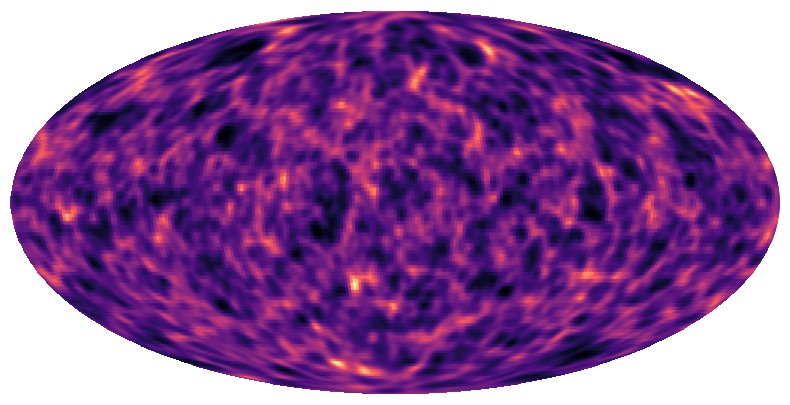

In [34]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Mollweide())
im = ax.imshow(f, transform=ccrs.PlateCarree(), cmap='magma')
plt.axis('off')
plt.show()

Before calling the scattering transform you need to run configuration, which will generate any precomputed arrays and cache them. When running the recursive transform this shouldn't take much memory at all. However, the fully precompute transform, which is much faster, can be extremely memory hungry at L ~ 512 and above!

In [35]:
config = s2scat.configure(L, N, J_min, reality)

## Compute anisotropic scattering covariances

Now all we have to do is apply ``S2SCAT`` to compute the statistics.

In [36]:
covariances = s2scat.scatter(flm, L, N, J_min, reality, config)

So what is actually in this covariances Tuple? Essentially it is a list of:

- covariances[0]: The field mean.
- covariances[1]: The field variance.
- covariances[2]: The mean power in each direction (S1).
- covariances[3]: The mean power in each wavelet scale (P00).
- covariances[4]: The fourth order covariance between two wavelet scales and two directions, defined as 

$$ \text{C01} = \text{Cov} \big[\Psi^{\lambda_1} f, \Psi^{\lambda_1} | \Psi^{\lambda_2} f | \big] $$

- covariances[5]: The sixth order covariance between three wavelet scales and three directions, defined as 

$$ \text{C11} = \text{Cov}\big [ \Psi^{\lambda_1} | \Psi^{\lambda_3} f |, \Psi^{\lambda_1} | \Psi^{\lambda_2} f | \big ] $$

In [37]:
for i in range(6):
    print("Number of coefficients for anisotropic covariance[{}]: {}".format(i, covariances[i].shape))

Number of coefficients for anisotropic covariance[0]: ()
Number of coefficients for anisotropic covariance[1]: ()
Number of coefficients for anisotropic covariance[2]: (40,)
Number of coefficients for anisotropic covariance[3]: (40,)
Number of coefficients for anisotropic covariance[4]: (700,)
Number of coefficients for anisotropic covariance[5]: (17500,)


## Compute isotropic scattering covariances

Instead, lets now compute the isotropic version of these statistics.

In [38]:
covariances = s2scat.scatter(flm, L, N, J_min, reality, config, isotropic=True)

These have much lower dimensionality that the anisotropic coefficients.

In [39]:
for i in range(6):
    print("Number of coefficients for isotropic covariance[{}]: {}".format(i, covariances[i].shape))

Number of coefficients for isotropic covariance[0]: ()
Number of coefficients for isotropic covariance[1]: ()
Number of coefficients for isotropic covariance[2]: (40,)
Number of coefficients for isotropic covariance[3]: (40,)
Number of coefficients for isotropic covariance[4]: (28,)
Number of coefficients for isotropic covariance[5]: (140,)


But they still encode significant non-Gaussian structural information!

## What next?

This compression may well be sufficient as it is for many applications.  Nevertheless, one may wish to go even further and consider applying other compression approaches as an additional stage.

In any case there are a number of use cases for the scattering covariances that extend beyond compression, such as emulation, where the scattering coefficients are used for a statistical generative model.  An overview for this is provided in another example notebook.